# 用 convnet 处理序列

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

np.random.seed(42)
tf.random.set_seed(42)

<font color='crimson'>convnet 在计算机视觉问题上表现出色的原因在于它能够进行卷积运算，从局部输入图块中提取特征，并能够将表示模块化，同时可以高效地利用数据。这些性质让 convnet 在 CV 中表现优异，同样也让它对序列处理特别有效。时间可以被看作一个空间维度，就像二维图像的高度或宽度。</font>

对于某些序列处理问题，这种 1D convnet 的效果可以媲美 RNN，而且计算代价通常要小很多。

## 1.  序列的 1D convoluation

- <font color='blue'>二维卷积从图像张量中提取二维图块并对每个图块应用相同的变换</font>


- <font color='blue'>使用一维卷积，从序列中提取局部一维序列段 (即子序列)</font>

![1D convnet](figs/chap06-figs/1D_convnet.png)

**<font color='crimson'>这种一维卷积层可以识别序列中的局部模式。因为对每个序列段执行相同的输入变换，所以在句子中某个位置学到的模式稍后可以在其他位置被识别，这使得 1D convnet 具有平移不变性 (对于时间平移而言)。</font>**

<font color='crimson'>使用大小为 5 的卷积窗口处理字符序列的 1D convnet ，应该能够学习长度不大于 5 的单词或单词片段，并且应该能够在输入句子中的任何位置识别这些单词或单词段。因此，字符级的 1D convnet 能够学会单词构词法。</font>

## 2. 序列的 1D pooling

从输入中提取一维序列段 (即子序列)， 然后输出其最大值 (最大池化) 或平均值 (平均池化)。

与 2D convnet 一样，该运算也是用于降低一维输入的长度 (子采样)。

## 3. 1D convnet

`tf.keras.layers.Conv1D` 输入 shape 是 `(samples, steps, input_dim)`，输出 shape 是 `(batch_size, new_steps, filters)`。卷积窗口 (kernel size) 是时间轴上的一维窗口 (时间轴是输入 tensor 的第二个轴)。

In [2]:
max_features = 10000
maxlen = 500

print("Load IMDB data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print("\nPad sequences...")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Load IMDB data...
25000 train sequences
25000 test sequences

Pad sequences...
x_train shape: (25000, 500)
x_test shape: (25000, 500)


**<font color='crimson'>1D convnet 可以使用更大的卷积窗口。</font>**

<font color='crimson'>对于 2D convoluation， 3×3 的卷积窗口包含 3×3=9 个特征向量，但对于 1D convoluation，大小为 3 的卷积窗口只包含 3 个卷积向量。因此，可以轻松使用大小等于 7 或 9 的一维卷积窗口。</font>

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 128, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),  # 500-7+1=494
    tf.keras.layers.MaxPool1D(5),  # 494//5
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 678us/sample - loss: 0.6926 - acc: 0.5216 - val_loss: 0.6917 - val_acc: 0.5266
Epoch 2/10
20000/20000 [==============================] - 8s 422us/sample - loss: 0.6864 - acc: 0.6810 - val_loss: 0.6851 - val_acc: 0.6722
Epoch 3/10
20000/20000 [==============================] - 8s 412us/sample - loss: 0.6709 - acc: 0.7552 - val_loss: 0.6583 - val_acc: 0.7544
Epoch 4/10
20000/20000 [==============================] - 8s 414us/sample - loss: 0.6189 - acc: 0.7910 - val_loss: 0.5763 - val_acc: 0.8034
Epoch 5/10
20000/20000 [==============================] - 8s 409us/sample - loss: 0.5073 - acc: 0.8291 - val_loss: 0.4566 - val_acc: 0.8274
Epoch 6/10
20000/20000 [==============================] - 8s 405us/sample - loss: 0.3927 - acc: 0.8540 - val_loss: 0.3759 - val_acc: 0.8468
Epoch 7/10
20000/20000 [==============================] - 8s 411us/sample - loss: 0.3216 - acc: 0.8773 - val_l

In [5]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

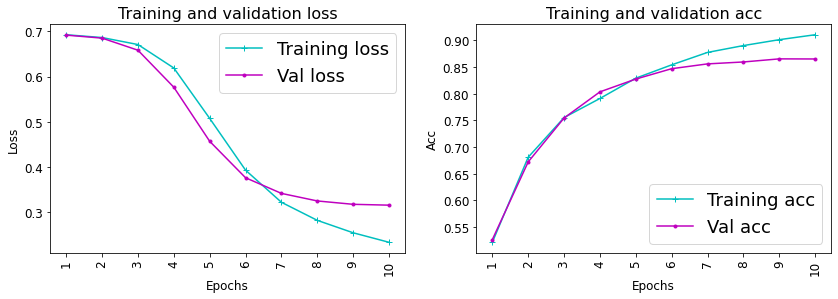

In [6]:
plot_history(history)

ACC 和 LSTM 的差不多，但速度快多了。

<font color='crimson'>在单词级的情感分类任务上，1D convnet 可以替代 RNN ，并且速度更快、计算代价 更低。</font>

## 4. 结合 CNN 和 RNN 来处理长序列

<font color='crimson'>1D convnet 分别处理每个输入序列段，所以它对时间步的顺序不敏感，这一点与 RNN 不同。(这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小。不关注局部的顺序，但是关注整体的顺序。)</font> 

当然，为了识别更长期的模式，可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。

In [7]:
def load_and_process_data():
    data = pd.read_csv(
        '/home/libing/datasets/jena_climate/jena_climate_2009_2016.csv')

    float_data = data.values[:, 1:]
    # 不然预处理时会出错
    float_data = float_data.astype('float64')

    # 数据预处理——让特征在相似的范围内都取较小的特征
    mean = float_data[:200000].mean(axis=0)
    float_data -= mean
    std = float_data[:200000].std(axis=0)
    float_data /= std

    return float_data

In [8]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
              batch_size=128, step=6):
    """生成一个元组 (samples, targets)。

    其中 samples 是输入数据的一个 batch，targets 是对应的目标温度数据。

    Parameters
    ----------
    data: np.array, 原始数据
    lookback: 输入数据应该包括过去多少个时间步
    delay: 目标应该在未来多少个时间步之后
    min_index 和 max_index: data 数组中的索引，用于界定需要抽取哪些时间步
    shuffle: 是否打乱数据。默认按顺序抽取数据
    batch_size: 每个 batch 的样本数
    step: 数据采样的周期/时间步。默认，每小时 (6 个时间步) 抽取一个数据点
    """
    # 确保在生成样本时，每个时间步之后都有 delay 个时间步数据，用于生成 target
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback  # 可以生成样本的起始时间步

    while True:
        if shuffle:  # 打乱数据，在范围内随机生成 batch_size 个时间步来生成样本
            rows = np.random.randint(i, max_index, size=batch_size)
            # rows = np.random.randint(min_index+lookback, max_index, size=batch_size)  # 原文代码
        else:
            # 如果超出 max_index，则从头开始
            # 为了可以一直生成数据，每次调用这个函数结果都是一样的
            if i + batch_size >= max_index:  # 神来之笔
                i = min_index + lookback
            # 生成 rows 数组，其范围从第 i 个时间步到第 i+batch_size 个时间步
            rows = np.arange(i, i+batch_size)
            # rows = np.arange(i, min(i+batch_size, max_index))  # 原文代码
            i += len(rows)

        # shape (batch_size, 采样数, 特征值)
        samples = np.zeros(shape=(len(rows),
                                  lookback // step,  # 每 step 采样一次数据
                                  data.shape[-1]))
        targets = np.zeros(shape=(len(rows), ))
        for j, row in enumerate(rows):
            # 在第 row 个时间步时，每隔 step 个时间步来采样过去 lookback 个时间步内的数据
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row+delay][1]  # 第 row+delay 个时间步的温度作为 target
        # 这里用的是 TensorFlow 2.0 GPU，不能加 [None]
        yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

float_data = load_and_process_data()

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu',
                           # None for variable-length sequences
                           input_shape=(None, float_data.shape[-1])),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen,
          steps_per_epoch=500,
          epochs=20,
          validation_data=val_gen,
          validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [11]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.show()

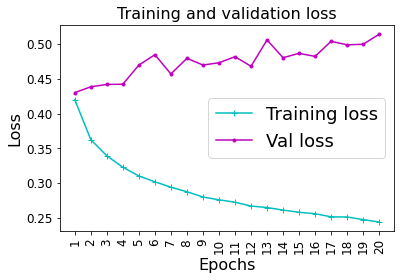

In [12]:
plt.figure(figsize=(6, 3.8))
plot_history(history)

单纯使用 1D convnet 的结果很差。

<font color='crimson'>这是因为 convnet 在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置 (距开始多长时间，距结束多长时间等)。</font> 对于这个具体的温度预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以 convnet 无法得到有意义的结果。<font color='crimson'>convnet 的这种限制对于 IMDB 数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。</font>

<div class="alert alert-block alert-info">
    <b>要想结合 convnet 的速度和轻量与 RNN 的顺序敏感性，一种方法是在 RNN 前面使用 1D convnet 作为预处理步骤。对于那些非常长，以至于 RNN 无法处理的序列 (比如包含上千个时间步的序列)，这种方法尤其有用。convnet 可以将长的输入序列转换为高级特征组成的更短序列 (下采样)。然后，提取的特征组成的这些序列成为网络中 RNN 的输入。</b>
</div>

![CNN+RNN](figs/chap06-figs/cnn_and_rnn.png)

<font color='crimson'>CNN+RNN 的方法可以处理更长的序列</font>，所以可以在这个问题中可以查看更早的数据 (增大 lookback) 或者查看分辨率更高的时间序列 (减小 step)。

In [13]:
step = 3
lookback = 1440  # Unchanged
delay = 144      # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [14]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu',
                           # None for variable-length sequences
                           input_shape=(None, float_data.shape[-1])),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.GRU(32, dropout=0.1),
    tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_gen,
          steps_per_epoch=500,
          epochs=20,
          validation_data=val_gen,
          validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 48s 97ms/step - loss

在本例中可能效果不是很好，但对于其他数据集可能非常重要。

**<font color='blue'>Summary:</font>**

- <font color='blue'>2D convnet 在二维空间中处理视觉模式时表现很好，与此相同，1D convnet 在处理时间模式时表现也很好。对于某些问题，特别是 NLP 任务，它可以替代 RNN，并且速度更快。</font>


- <font color='blue'>通常情况下，1D convnet 的架构与 2D convnet 很相似，它将 `Conv1D` 层和 `MaxPool1D` 层堆叠在一起，最后是一个 `GlobalMaxPool1D` 或 `GlobalAveragePool1D` 或 `Flatten`。</font>


- <font color='blue'>因为 RNN 在处理非常长的序列时计算代价很大，但 1D convnet 的计算代价很小， 所以在 RNN 之前使用 1D convnet 作为预处理步骤是一个好主意，这样可以使序列变短，并提取出有用的表示交给 RNN 来处理。</font>


- <font color='crimson'>如果序列数据的整体顺序很重要，那么最好使用 RNN 来处理。时间序列通常都是这样，最近的数据可能比久远的数据包含更多的信息量。</font>


- <font color='crimson'>如果整体顺序没有意义，那么 1D convnet 可以实现同样好的效果，而且计算代价更小。文本数据通常都是这样，在句首发现关键词和在句尾发现关键词一样都很有意义。</font>